In [1]:
import math
import random

import autograd.numpy        as np
import autograd.numpy.random as npr 

from autograd.scipy.stats import norm
from autograd             import jacobian, grad

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class TimeAveragedDist(object):    
    
    def __init__(self, explr_idx=[0], log_std=0., capacity=100):    
    
        self.log_std   = log_std    
        self.capacity  = capacity    
        self.explr_idx = explr_idx     
    
    
    def log_prob(self, x, s, grad=False):    
        """ Calculates the log probability of the time averaged distribution      
        """    
        if grad:    
            return -(x[self.explr_idx]-s)/np.exp(self.log_std)    
        return -0.5 * self.log_std - 0.5 * np.sum((x[:, self.explr_idx]-s)/np.exp(self.log_std),1)    


In [3]:
dist = TimeAveragedDist()

In [ ]:
x = npr.

## Environment
Here, we use a 1-D environment where a robot has access in the $x$-space.

In [3]:
class SingleIntegratorEnv(object):

    def __init__(self):

        self.num_states = 2
        self.num_actions = 1
        self.dt = 0.1

        self.A = np.array([
            [0., 1.0, 0.],
            [0., 0., 1.0]
        ])
        
    def get_lin(self, x, u):
        return self.A[:, :self.num_states], self.A[:, self.num_states:]
        
    def reset(self, state=None):

        if state is None:
            self.state = npr.uniform(-.1, .1, size=(self.num_states,))
        else:
            self.state = state.copy()

        return self.state.copy()

    def f(self, x, u):
        inputs = np.hstack((x, u))
        return np.dot(self.A, inputs)

    def step(self, u):
        self.state = self.state + self.f(self.state, u) * self.dt
        return self.state.copy()

## Create a buffer, target distribution, and the KL-E3 algorithm

In [10]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = state
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return np.stack(batch)

    def __len__(self):
        return len(self.buffer)
    
class TargetDistr(object):
    
    def __init__(self):
        
        self.explr_dim = 1
        
        
        self.mu        = np.stack([np.array([-1.]), np.array([2.])])
        self.pi        = np.array([0.4,  0.6])
        self.num_gauss = len(self.pi)

        self.std       = np.stack([np.array([0.5]), np.array([0.8])])

    def gumbel_sample(self, n):
        pi = np.repeat(self.pi.reshape(-1,self.num_gauss), n, axis=0)
        z  = np.random.gumbel(loc=0, scale=1, size=pi.shape)
        return (np.log(pi) + z).argmax(axis=1)

    def sample(self, n=1):
        k   = self.gumbel_sample(n)
        idx = (np.arange(n), k)
        mu  = np.repeat(self.mu.reshape(-1, self.num_gauss, self.explr_dim), n, axis=0)
        std = np.repeat(self.std.reshape(-1, self.num_gauss, self.explr_dim), n, axis=0)
        
        s = npr.normal(mu[idx], std[idx])
        return s
    
    def pdf(self, x):
        out = 0.
        for mu, pi, std in zip(self.mu, self.pi, self.std):
            out += pi * norm.pdf(x, mu, std)
        return out + 1e-4


    
class KLErg(object):
    
    def __init__(self, num_states, num_actions, 
                 target_distr, explr_idx=[0],
                 horizon=100, capacity=100, std=0.05):
        
        self.target_distr = target_distr
        self.explr_idx    = explr_idx
        self.num_states   = num_states
        self.num_actions  = num_actions
        self.horizon      = horizon
        self.std          = std
        self.buffer       = ReplayBuffer(capacity)
        self.u_seq        = [np.zeros(num_actions) for _ in range(horizon)]
        
        self.grad         = jacobian(self.footprint)
        self.barr_grad    = grad(self.barrier)
    
    def barrier(self, x):
        return 100.*(x[0]/10.)**8
    
    def footprint(self, x, s):
        return np.exp(-0.5 * np.sum(np.square(x[self.explr_idx] - s)/self.std, 1))
    
    def pdf(self, x_t, s):
        pdf = -0.5 * np.sum(np.square(x_t[:, self.explr_idx] - s)/self.std, 1)
        pdf = np.mean(np.exp(pdf),0) + 1e-5
        return pdf
                    
    def __call__(self, state, model, n=20, eps=10., batch_size=20):
        
        self.u_seq[:-1] = self.u_seq[1:]
        self.u_seq[-1] = np.zeros(self.num_actions)
        
        derivs = []
        traj   = []
        x      = model.reset(state)
        s      = npr.uniform(-5., 5., size=(n, 1))
        p      = self.target_distr.pdf(s)
        p      /= np.sum(p)
        
        # forward simulate
        for t in range(self.horizon):
            
            # compute derivatives 
            A, B = model.get_lin(x, self.u_seq[t])
            gdx  = self.grad(x, s)
            bdx  = self.barr_grad(x)
            
            # store the derivatives
            derivs.append((gdx, A, B, bdx))
            traj.append(x)
            
            # step forward
            x    = model.step(self.u_seq[t])
            
        path = np.stack(traj)
        if len(self.buffer) > batch_size:
            p_states = self.buffer.sample(batch_size)
            path = np.vstack([path, p_states])

        q    = np.array([self.pdf(path, si) for si in s])
        q    = q.reshape(-1,1)
        q    /= np.sum(q)
        
        like_ratio = p/q
        rho = np.zeros(x.shape)
        for t in reversed(range(self.horizon)):
            gdx, A, B, bdx = derivs[t]
            rho = rho - model.dt * (np.mean(like_ratio * gdx, 0) - A.T.dot(rho) - bdx)
            self.u_seq[t] = np.clip(-eps*B.T.dot(rho) + self.u_seq[t], -2., 2.)

        return self.u_seq[0]
            

## Instantiate the environment, model, target distribution, and KL-E^3

In [11]:
npr.seed(0)

env   = SingleIntegratorEnv()
model = SingleIntegratorEnv()

t_dist = TargetDistr()
kl_explr = KLErg(env.num_states, env.num_actions, t_dist, horizon=15)

## Simulate a trajectory 

In [12]:
trajectory = []
state = env.reset()
for _ in range(600):
    trajectory.append(state)
    a = kl_explr(state, model, eps=100., n=40, batch_size=20)
    state = env.step(a)
    kl_explr.buffer.push(state)

## Plot trajectory and resulting distributions

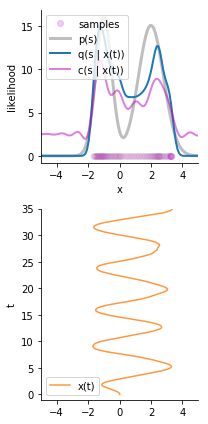

In [13]:
tf = 400

traj = np.stack(trajectory)
t = [i * env.dt for i in range(tf)]

xx = np.linspace(-5, 5, 100)
scale = 500

target_dist = [t_dist.pdf(xi) * scale for xi in xx]
target_dist = np.array(target_dist)
target_dist /= np.sum(target_dist)
target_dist *= scale

time_dist = [kl_explr.pdf(traj[:tf], xi) * scale for xi in xx]
time_dist = np.array(time_dist)
time_dist /= np.sum(time_dist)
time_dist *= scale


### Fourier decomp
num_basis = 20
cks = [np.mean(np.cos(k * (traj[:tf,0] + 5.0) * np.pi / (10.))) for k in range(num_basis)]
recon = np.zeros(xx.shape)
for k in range(num_basis):
    recon += cks[k] * np.cos(k * (xx + 5.0) * np.pi/10.)
recon /= np.sum(recon)
recon *= scale

fig, axs = plt.subplots(2, 1, figsize=(3,6), gridspec_kw={'height_ratios': [0.8, 1]})

axs[1].plot(traj[:tf,0], t, alpha=0.8, label='x(t)', color='tab:orange')
axs[0].plot(traj[:tf,0], np.zeros(traj[:tf,0].shape), 'o', alpha=0.01, color='m')
axs[0].plot(traj[50:52,0], np.zeros(traj[50:52,0].shape), 'o', alpha=0.2, color='m', label='samples')

# axs[0].plot([-5, 5], [0,0] , alpha=1.0, color='k', lw=1.)

axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

axs[1].set_ylabel('t')
axs[1].set_xlim(-5,5)
axs[1].set_ylim(-1,35)

axs[1].legend()

axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

axs[0].plot(xx,target_dist, 'tab:gray', alpha=0.5, lw=3, label='p(s)')
axs[0].plot(xx,time_dist, 'tab:blue', alpha=1.0, lw=2, label='q(s | x(t))')
axs[0].plot(xx,recon, 'm', alpha=0.5, lw=2, label='c(s | x(t))')
axs[0].set_ylabel('likelihood')
axs[0].set_xlim(-5,5)

axs[0].set_xlabel('x')

axs[0].legend()

plt.tight_layout()

plt.show()

## Make a cool video 

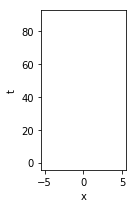

In [14]:
# from matplotlib import pyplot as plt
from celluloid import Camera

fig = plt.figure(figsize=(2,3))
camera = Camera(fig)

t = [i * env.dt for i in range(len(traj))]


target_dist = [t_dist.pdf(xi) * scale for xi in xx]
target_dist = np.array(target_dist)
target_dist /= np.sum(target_dist)
target_dist *= scale

for i in range(1,len(traj), 10):
    
#     plt.clf()
    
    plt.plot(traj[:i, 0], t[:i], 'm', label='trajectory')
    time_dist = [kl_explr.pdf(traj[:i], xi) * scale for xi in xx]
    time_dist = np.array(time_dist)
    time_dist /= np.sum(time_dist)
    time_dist *= scale
    
    
    
    plt.plot(xx, time_dist, color='b', label='trajectory dist.')
    plt.plot(xx, target_dist, color='g', label='target dist.')
    plt.plot(traj[:i,0], np.zeros(traj[:i,0].shape), 'o', alpha=0.01, color='m', label='samples')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.tight_layout()
    camera.snap()
    
animation = camera.animate()
animation.save('./distr_match.gif', writer = 'imagemagick', fps=10)